In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import glob
import cv2,math,os
import keras
import json,shutil
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [0]:
import numpy as np
import tensorflow as tf
import glob,os,cv2


class VideoFrameGenerator(tf.keras.utils.Sequence):
    """
    Create a generator that return batches of frames from video
    - rescale: float fraction to rescale pixel data (commonly 1/255.)
    - nb_frames: int, number of frames to return for each sequence
    - classes: list of str, classes to infer
    - batch_size: int, batch size for each loop
    - use_frame_cache: bool, use frame cache (may take a lot of memory for \
        large dataset)
    - shape: tuple, target size of the frames
    - shuffle: bool, randomize files
    - transformation: ImageDataGenerator with transformations
    - split: float, factor to split files and validation
    - nb_channel: int, 1 or 3, to get grayscaled or RGB images
    - glob_pattern: string, directory path with '{classname}' inside that \
        will be replaced by one of the class list
    - _validation_data: already filled list of data, **do not touch !**
    You may use the "classes" property to retrieve the class list afterward.
    The generator has that properties initialized:
    - classes_count: number of classes that the generator manages
    - files_count: number of video that the generator can provides
    - classes: the given class list
    - files: the full file list that the generator will use, this \
        is usefull if you want to remove some files that should not be \
        used by the generator.
    """

    def __init__(
            self,
            rescale=1/255.,
            nb_frames: int = 5,
            classes: list = [],
            batch_size: int = 16,
            use_frame_cache: bool = False,
            target_shape: tuple = (648, 384),
            shuffle: bool = True,
            transformation: tf.keras.preprocessing.image.ImageDataGenerator = None,
            split: float = None,
            nb_channel: int = 3,
            glob_pattern: str = './videos/{classname}/*.avi',
            _validation_data: list = None):

        # should be only RGB or Grayscale
        assert nb_channel in (1, 3)

        # we should have classes
        assert len(classes) != 0

        # shape size should be 2
        assert len(target_shape) == 2

        # split factor should be a propoer value
        if split is not None:
            assert 0.0 < split < 1.0

        # be sure that classes are well ordered
        classes.sort()

        self.rescale = rescale
        self.classes = classes
        self.batch_size = batch_size
        self.nbframe = nb_frames
        self.shuffle = shuffle
        self.target_shape = target_shape
        self.nb_channel = nb_channel
        self.transformation = transformation
        self.use_frame_cache = use_frame_cache

        self._random_trans = []
        self.__frame_cache = {}
        self.files = []
        self.validation = []

        if _validation_data is not None:
            # we only need to set files here
            self.files = _validation_data
        else:
            if split is not None and split > 0.0:
                for cls in classes:
                    files = glob.glob(glob_pattern.format(classname=cls))
                    nbval = int(split * len(files))

                    print("class %s, validation count: %d" % (cls, nbval))

                    # generate validation indexes
                    indexes = np.arange(len(files))

                    if shuffle:
                        np.random.shuffle(indexes)

                    val = np.random.permutation(
                        indexes)[:nbval]  # get some sample
                    # remove validation from train
                    indexes = np.array([i for i in indexes if i not in val])

                    # and now, make the file list
                    self.files += [files[i] for i in indexes]
                    self.validation += [files[i] for i in val]

            else:
                for cls in classes:
                    self.files += glob.glob(glob_pattern.format(classname=cls))

        # build indexes
        self.files_count = len(self.files)
        self.indexes = np.arange(self.files_count)
        self.classes_count = len(classes)

        # to initialize transformations and shuffle indices
        self.on_epoch_end()

        print("get %d classes for %d files for %s" % (
            self.classes_count,
            self.files_count,
            'train' if _validation_data is None else 'validation'))

    def get_validation_generator(self):
        """ Return the validation generator if you've provided split factor """
        return self.__class__(
            nb_frames=self.nbframe,
            nb_channel=self.nb_channel,
            target_shape=self.target_shape,
            classes=self.classes,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            rescale=self.rescale,
            _validation_data=self.validation)

    def on_epoch_end(self):
        """ Called by Keras after each epoch """

        if self.transformation is not None:
            self._random_trans = []
            for i in range(self.files_count):
                self._random_trans.append(
                    self.transformation.get_random_transform(self.target_shape)
                )

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(self.files_count / self.batch_size))

    def __getitem__(self, index):
        classes = self.classes
        shape = self.target_shape
        nbframe = self.nbframe

        labels = []
        images = []

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        transformation = None

        for i in indexes:
            # prepare a transformation if provided
            if self.transformation is not None:
                transformation = self._random_trans[i]

            # video = random.choice(files)
            video = self.files[i]
            classname = video.split(os.sep)[-2]

#            create a label array and set 1 to the right column
            label = np.zeros(len(classes))
            col = classes.index(classname)
            label[col] = 1.
            # label = [0,1]
            # label = np.array(label)

            if video not in self.__frame_cache:
                cap = cv2.VideoCapture(video)
                frames = []
                while True:
                    grabbed, frame = cap.read()
                    if not grabbed:
                        # end of video
                        break

                    # resize
                    frame = cv2.resize(frame, shape)

                    # use RGB or Grayscale ?
                    if self.nb_channel == 3:
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    else:
                        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

                    # to np
                    frame = tf.keras.preprocessing.image.img_to_array(
                        frame) * self.rescale

                    # keep frame
                    frames.append(frame)

                # Add 2 frames to drop first and last frame
                jump = len(frames)//(nbframe+2)
                

                # get only some images
                try:
                    frames = frames[jump::jump][:nbframe]
                except Exception as exception:
                    print(video)
                    raise exception

                # add to frame cache to not read from disk later
                if self.use_frame_cache:
                    self.__frame_cache[video] = frames
            else:
                frames = self.__frame_cache[video]

            # apply transformation
            if transformation is not None:
                frames = [self.transformation.apply_transform(
                    frame, transformation) for frame in frames]
                # print(frames)

            # add the sequence in batch
            images.append(frames)
            labels.append(label)

        return np.array(images), np.array(labels)


"""
Utils module to provide some nice functions to develop with Keras and
Video sequences.
"""

import random as rnd
import matplotlib.pyplot as plt


def show_sample(g, index=0, random=False, row_width=19, row_height=10):
    """ Displays a batch using matplotlib.

    params:

    - g: keras video generator
    - index: integer index of batch to see (overriden if random is True)
    - random: boolean, if True, take a random batch from the generator
    - row_width: integer to give the figure height
    - row_height: integer that represents one line of image, it is multiplied by \
    the number of sample in batch.
    """
    total = len(g)
    print("Total: ",total)
    if random:
        sample = rnd.randint(0, total)
    else:
        sample = index

    assert index < len(g)
    sample = g[sample]
    sequences = sample[0]
    labels = sample[1]

    rows = len(sequences)
    index = 1
    plt.figure(figsize=(row_width, row_height*rows))
    for batchid, sequence in enumerate(sequences):
        classid = np.argmax(labels[batchid])
        classname = g.classes[classid]
        cols = len(sequence)
        for image in sequence:
            print(classname,index)
            plt.subplot(rows, cols, index)
            plt.title(classname)
            plt.imshow(image)
            # plt.axis('off')
            index += 1
    plt.show()


In [0]:
size = (648, 384)
CHANNELS = 3
NBFRAME = 5
batch_size = 4

classes = ['REAL','FAKE']
class_list,name_of_files = [], []

with open("/content/drive/My Drive/DeepFakeFiles/metadata.json") as f:
    data = json.load(f)
    for video_id,info in data.items():
        if info['label'] == 'FAKE':
            class_list.append(1)
        else:
            class_list.append(0)
        name_of_files.append(video_id)

In [5]:
glob_pattern = '/content/drive/My Drive/DeepFakeFiles/{classname}/*.mp4'

data_aug = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=.1,horizontal_flip=True,rotation_range=8,width_shift_range=.2,height_shift_range=.2)
train = VideoFrameGenerator(classes=classes, glob_pattern=glob_pattern,nb_frames=NBFRAME,split=None, shuffle=False,batch_size=batch_size,target_shape=size,nb_channel=CHANNELS,transformation=data_aug,use_frame_cache=True)
valid = train.get_validation_generator()
  

get 2 classes for 400 files for train
get 2 classes for 0 files for validation


In [6]:
a,b = train[0]
print(b)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


AUDIO MODEL

In [0]:
import librosa
def get_audio_array(filename):
  sound,sr = librosa.load(filename)
  sound = np.array(sound)
  return sound

In [0]:
print(name_of_files.index('aagfhgtpmv.mp4'))

0


In [0]:
paths = glob.glob("/content/drive/My Drive/DeepFakeFiles/Audio/FAKE/*.mp3")
X_list = []
for path in paths:
  sound = get_audio_array(path)
  X_list.append(sound)
  print(os.path.basename(path))
X = np.array(X_list)  
print(X,X.shape)

In [0]:
paths = glob.glob("/content/drive/My Drive/DeepFakeFiles/Audio/REAL/*.mp3")
for path in paths:
  sound = get_audio_array(path)
  X_list.append(sound)
  print(os.path.basename(path))
X = np.array(X_list) 

In [0]:
X.shape
start = 0
step = batch = 100
while batch<=400:
  print(start,batch)
  np.save("/content/drive/My Drive/DeepFakeFiles/{}.npy".format(batch),X[start:batch,:])
  start = batch
  batch += step

0 100
100 200
200 300
300 400


In [0]:
Y = []
for i in ['FAKE','REAL']:
  paths = glob.glob('/content/drive/My Drive/DeepFakeFiles/Audio/{}/*.mp3'.format(i))
  for path in paths:
    basename = os.path.basename(path).split('.')[0]+'.mp4'
    Y.append(class_list[name_of_files.index(basename)])
Y = np.array(Y)
Y = Y.reshape(-1,1)    
print(Y,Y.shape)    

In [0]:
start = 0
step = batch = 100
while batch<=400:
  print(start,batch)
  np.save("/content/drive/My Drive/DeepFakeFiles/Y_{}.npy".format(batch),Y[start:batch,:])
  start = batch
  batch += step

0 100
100 200
200 300
300 400


In [0]:
import joblib
class AudioGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, ids, train_dir):
        'Initialization'
        self.ids = ids
        self.train_dir = train_dir

    def __len__(self):
        'Denotes the number of batches per epoch'
        return 4

    def __getitem__(self, index):
        batch_id = self.ids[index]
        # load data
        X = np.asarray(np.load(self.train_dir + str(batch_id*100) + '.npy'))
        Y = np.asarray(np.load(self.train_dir +'Y_'+ str(batch_id*100) + '.npy'))
        from sklearn import preprocessing
        enc = preprocessing.LabelBinarizer()
        Y = Y.reshape(-1,1)
        enc.fit(Y)
        #   joblib.dump(enc,"/content/drive/My Drive/DeepFakeFiles/Encoder")
        # enc = joblib.load("/content/drive/My Drive/DeepFakeFiles/Encoder")
        Y = Y.reshape(-1,1)  
        Y = enc.transform(Y)
        X = X.reshape(X.shape[0],X.shape[1],1)
        # X = np.asarray(X,dtype=np.uint8)
        # Y = np.asarray(Y,dtype=np.uint8)
        # print(X.shape,Y.shape)
        start=0
        batch,size= 4,4
        X_temp = X[start:batch,:]
        Y_temp = Y[start:batch,:]
        start = batch
        batch+=size
        # print(X_temp.shape,Y_temp.shape)
        return X_temp,Y_temp


In [0]:
train_gen = AudioGenerator(range(1,5),'/content/drive/My Drive/DeepFakeFiles/')

In [112]:
print(train_gen[0])

(100, 220941, 1) (100, 1)
(4, 220941, 1) (4, 1)
(array([[[ 1.5547655e-02],
        [ 2.9936353e-02],
        [ 1.9147202e-02],
        ...,
        [ 3.6545873e-02],
        [ 2.9443327e-02],
        [ 2.5040535e-02]],

       [[ 2.5070978e-03],
        [ 4.2573069e-03],
        [ 2.6458320e-03],
        ...,
        [ 6.8707025e-04],
        [ 7.7205128e-04],
        [ 9.3067414e-04]],

       [[-1.5908275e-03],
        [-3.8318003e-03],
        [-4.0873894e-03],
        ...,
        [-8.3098756e-03],
        [-8.8810073e-03],
        [-1.0186618e-02]],

       [[-4.4979475e-04],
        [-5.6146423e-04],
        [-1.8935485e-04],
        ...,
        [ 1.3175157e-04],
        [ 1.2352633e-04],
        [ 5.0074308e-05]]], dtype=float32), array([[0],
       [0],
       [0],
       [0]]))


In [0]:
def build_convnet(shape=(648, 384, 3)):
    momentum = .9
    input_shape = tf.keras.layers.Input(shape=shape)
    Conv2d1 = tf.keras.layers.Conv2D(64, (2,2), input_shape=shape,padding='same', activation='relu')(input_shape)
    Conv2d2 = tf.keras.layers.Conv2D(64, (2,2), padding='same', activation='relu')(Conv2d1)
    BN1 = (tf.keras.layers.BatchNormalization(momentum=momentum))(Conv2d2)

    MP1 = tf.keras.layers.MaxPool2D()(BN1)

    Conv2d3 = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(MP1)
    Conv2d4 = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(Conv2d3)
    BN2 = tf.keras.layers.BatchNormalization(momentum=momentum)(Conv2d4)

    MP2 = tf.keras.layers.MaxPool2D()(BN2)

    Conv2d5 = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(MP2)
    Conv2d6 = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(Conv2d5)
    BN3 = tf.keras.layers.BatchNormalization(momentum=momentum)(Conv2d6)

    OutputGMP = tf.keras.layers.GlobalMaxPool2D()(BN3)

    model = tf.keras.models.Model(inputs=input_shape,outputs=OutputGMP)
    

    print("CONVNET MODEL",model.summary())
    return model

In [0]:
def action_model(shape=(5, 648, 384, 3)):
    input_shape = tf.keras.layers.Input(shape=shape)

    convnet = build_convnet(shape[1:])

    input_shape = tf.keras.layers.Input(shape)
    TD = tf.keras.layers.TimeDistributed(convnet)(input_shape)

    LSTM1 = tf.keras.layers.LSTM(1024)(TD)

    Dense1 = tf.keras.layers.Dense(512, activation='relu')(LSTM1)
    Drop1 = tf.keras.layers.Dropout(.2)(Dense1)
    Dense2 = tf.keras.layers.Dense(128, activation='relu')(Drop1)
    Drop2 = tf.keras.layers.Dropout(.2)(Dense2)
    Dense3 = tf.keras.layers.Dense(64, activation='relu')(Drop2)

    model = tf.keras.models.Model(inputs=input_shape,outputs=Dense3)
    print("ACTION MODEL: ",model.summary())

    return model

In [0]:
def audio_and_final_model(shape=(220941,1)):
  input_shape = tf.keras.layers.Input(shape=shape)
  Conv1 = tf.keras.layers.Conv1D(16,activation='relu',kernel_size=(10))(input_shape)
  MaxPool1 = tf.keras.layers.MaxPool1D()(Conv1)
  Dropout1 = tf.keras.layers.Dropout(0.2)(MaxPool1)
  Conv2 = tf.keras.layers.Conv1D(32,activation='relu',kernel_size=(10))(Dropout1)
  MaxPool2 = tf.keras.layers.MaxPool1D()(Conv2)
  Dropout2 = tf.keras.layers.Dropout(0.2)(MaxPool2)
  Conv3 = tf.keras.layers.Conv1D(16,activation='relu',kernel_size=(10))(Dropout2)
  MaxPool3 = tf.keras.layers.MaxPool1D()(Conv3)
  Dropout3 = tf.keras.layers.Dropout(0.2)(MaxPool3)
  Flatten = tf.keras.layers.Flatten()(Dropout3)
  Dense1 = tf.keras.layers.Dense(128,activation='relu')(Flatten)
  Dense2 = tf.keras.layers.Dense(64,activation='relu')(Dense1)

  model = tf.keras.models.Model(inputs=input_shape,outputs=Dense2)

  print("AUDIO MODEL",model.summary())
  return model

In [0]:
def final_model(afmodel,amodel):
  model_layer1 = audio_and_final_model()
  model_layer2 = action_model()
  final_model = tf.keras.models.Sequential()
  final_model.add(tf.keras.layers.concatenate([model_layer2, model_layer1]))
  final_model.add(tf.keras.layers.Dense(2,activation='softmax'))
  return model

In [0]:
import itertools
def create_data_generator(video_generator,audio_generator):
    while(True):
        _video_generator, _lvideo_generator = video_generator[0],video_generator[1]
        _audio_generator, _laudio_generator = audio_generator[0],audio_generator[1]

        yield [_video_generator,_audio_generator], [_lvideo_generator,_laudio_generator]

In [0]:
multiple_data_generator = create_data_generator(train,train_gen)

In [15]:
am = action_model()
afm = audio_and_final_model()

combined = tf.keras.layers.Concatenate(axis=-1)([am.output,afm.output])
z = tf.keras.layers.Dense(2,activation='softmax')(combined)

model = tf.keras.models.Model(inputs=[am.input,afm.input],outputs=z)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 648, 384, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 648, 384, 64)      832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 648, 384, 64)      16448     
_________________________________________________________________
batch_normalization (BatchNo (None, 648, 384, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 324, 192, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 324, 192, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 324, 192, 128)     147584

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 220941, 1)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 220932, 16)   176         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 110466, 16)   0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 110466, 16)   0           max_pooling1d[0][0]              
____________________________________________________________________________________________

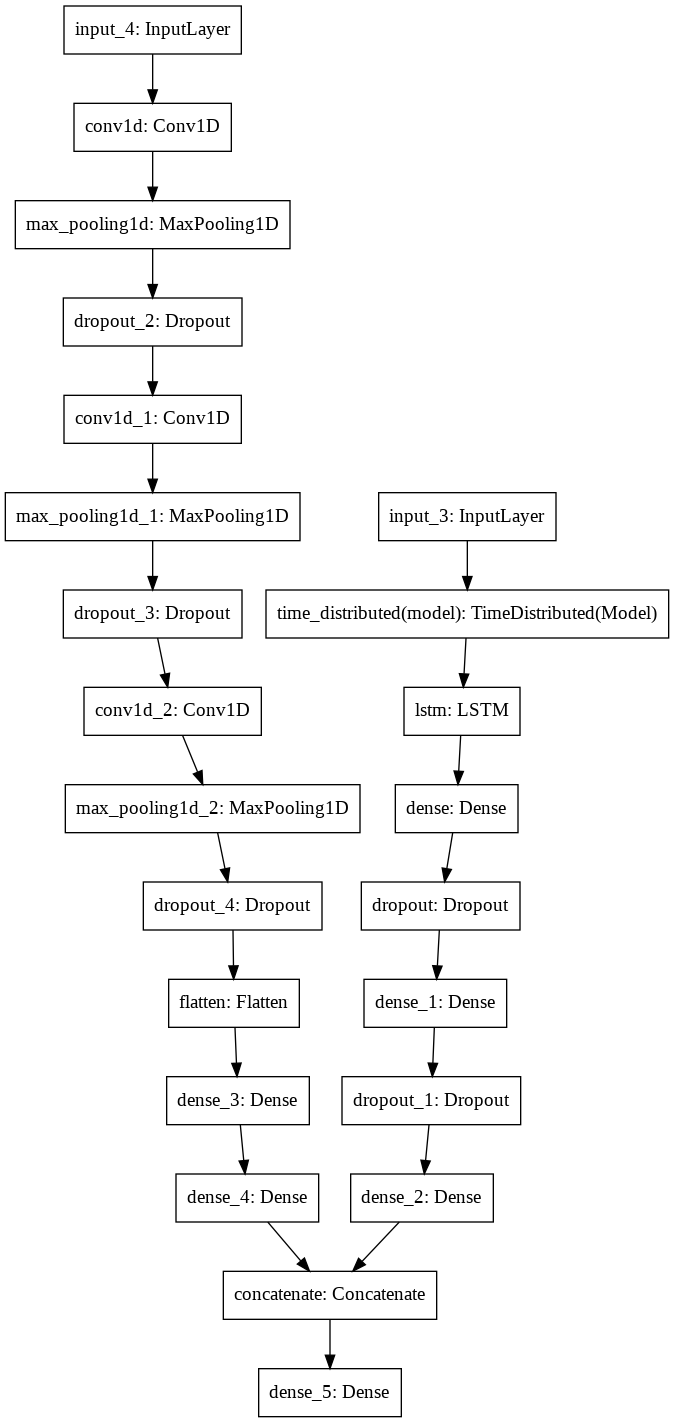

In [16]:
model.summary()
tf.keras.utils.plot_model(model)

In [18]:
INSHAPE = (5, 648, 384, 3)
print("Inshape",INSHAPE)
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer,'binary_crossentropy',metrics=['acc'])
print(model.summary())
EPOCHS=10
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(verbose=1,monitor='loss'),tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/DeepFakeFiles/Model.h5',monitor='loss',save_best_only=True,save_freq='epoch')]
print("Starting training")
model.fit(multiple_data_generator,verbose=1,epochs=EPOCHS,callbacks=callbacks)
print("Saving Model")
model.save("DeepfakeModel.h5")

Inshape (5, 648, 384, 3)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 220941, 1)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 220932, 16)   176         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 110466, 16)   0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 110466, 16)   0           max_pooling1d[0][0]              
___________________________________________________________________

ValueError: ignored